In [29]:
import os
import torch
import numpy as np
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
 
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image

In [30]:
NUM_EPOCHS = 20
LEARNING_RATE = 1e-3
BATCH_SIZE = 128
# image transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [31]:
trainset = datasets.FashionMNIST(
    root='./data',
    train=True, 
    download=True,
    transform=transform
)
testset = datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)
trainloader = DataLoader(
    trainset, 
    batch_size=BATCH_SIZE,
    shuffle=True
)
testloader = DataLoader(
    testset, 
    batch_size=BATCH_SIZE, 
    shuffle=True
)

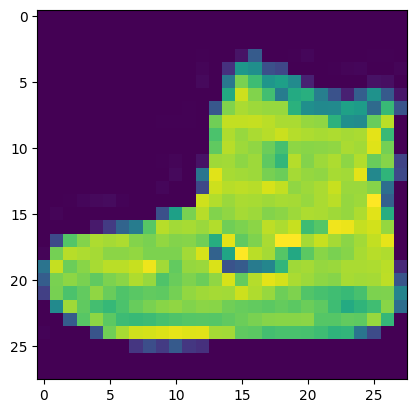

In [32]:
plt.imshow(trainset[0][0].permute(1,2,0))

In [33]:
def make_dir():
    image_dir = 'FashionMNIST_Images'
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)

In [34]:
def save_decoded_image(img, epoch):
    img = img.view(img.size(0), 1, 28, 28)
    save_image(img, './FashionMNIST_Images/linear_ae_image{}.png'.format(epoch))

In [35]:
class FullyConnectedAutoencoder(nn.Module):
    def __init__(self):
        super(FullyConnectedAutoencoder, self).__init__()
        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(in_features=784, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=16),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features=16, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=784),
            nn.ReLU()
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
FCnet = FullyConnectedAutoencoder()
# print(net)

In [36]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(FCnet.parameters(), lr=LEARNING_RATE)

In [37]:
def train(net, trainloader, NUM_EPOCHS):
    train_loss = []
    for epoch in range(NUM_EPOCHS):
        running_loss = 0.0
        for data in trainloader:
            img, _ = data
            img = img.view(img.size(0), -1)
            optimizer.zero_grad()
            outputs = net(img)
            loss = loss_fn(outputs, img)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        loss = running_loss / len(trainloader)
        train_loss.append(loss)
        print('Epoch {} of {}, Train Loss: {:.3f}'.format(
            epoch+1, NUM_EPOCHS, loss))
        if epoch % 5 == 0:
            save_decoded_image(outputs.cpu().data, epoch)
    return train_loss

def test_image_reconstruction(net, testloader):
     for batch in testloader:
        img, _ = batch
        img = img.view(img.size(0), -1)
        outputs = net(img)
        outputs = outputs.view(outputs.size(0), 1, 28, 28).cpu().data
        save_image(outputs, 'fashionmnist_reconstruction.png')
        break

Epoch 1 of 20, Train Loss: 0.078
Epoch 2 of 20, Train Loss: 0.052
Epoch 3 of 20, Train Loss: 0.044
Epoch 4 of 20, Train Loss: 0.038
Epoch 5 of 20, Train Loss: 0.034
Epoch 6 of 20, Train Loss: 0.030
Epoch 7 of 20, Train Loss: 0.029
Epoch 8 of 20, Train Loss: 0.028
Epoch 9 of 20, Train Loss: 0.026
Epoch 10 of 20, Train Loss: 0.026
Epoch 11 of 20, Train Loss: 0.025
Epoch 12 of 20, Train Loss: 0.024
Epoch 13 of 20, Train Loss: 0.023
Epoch 14 of 20, Train Loss: 0.022
Epoch 15 of 20, Train Loss: 0.022
Epoch 16 of 20, Train Loss: 0.021
Epoch 17 of 20, Train Loss: 0.021
Epoch 18 of 20, Train Loss: 0.021
Epoch 19 of 20, Train Loss: 0.021
Epoch 20 of 20, Train Loss: 0.020


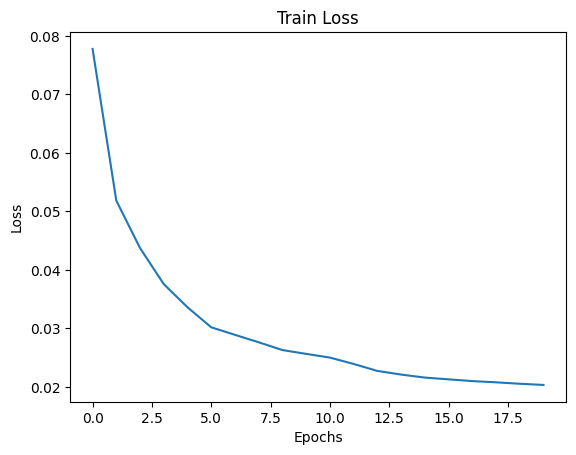

In [38]:
make_dir()

train_loss = train(FCnet, trainloader, NUM_EPOCHS)
plt.figure()
plt.plot(train_loss)
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('deep_ae_fashionmnist_loss.png')

test_image_reconstruction(FCnet, testloader)

In [40]:
from ipywidgets import interactive

def plot(z1, z2, z3, z4):
    plt.figure(2)
    z = torch.Tensor([[z1, z2, z3, z4]])
    z_padded = torch.zeros(1, 16)
    z_padded[:, :4] = z
    decoded = FCnet.decoder(z_padded)
    img = decoded.reshape(28, 28).to('cpu').detach().numpy()
    plt.imshow(img, cmap='gray')
    plt.show()

interactive_plot = interactive(plot, z1=(-3., 3., 0.01), z2=(-3., 3., 0.01), z3=(-3., 3., 0.01), z4=(-3., 3., 0.01))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=0.0, description='z1', max=3.0, min=-3.0, step=0.01), FloatSlider(valu…